In [2]:
import pandas as pd 
import tensorflow as tf
import numpy as np

import ssl
ssl._create_default_https_context = ssl._create_unverified_context
url = 'http://hilpisch.com/aiif_eikon_id_eur_usd.csv'
symbol='EUR_USD'
raw = pd.read_csv(url,index_col=0,parse_dates=True)

def generate_data():
  data = pd.DataFrame(raw['CLOSE'])
  data.columns=[symbol]
  data = data.resample('30min',label='right').last().ffill()
  return data 

In [4]:
lags=5

In [5]:
from keras.models import Sequential
from keras.layers import SimpleRNN ,Dense,LSTM

def create_rnn_model(hu=100,lags=lags,layer='SimpleRNN',features=1,algorithm='estimation'):
  model=Sequential()
  if layer is 'SimpleRNN':
    model.add(SimpleRNN(hu,activation='relu',input_shape=(lags,features)))

  else:
    model.add(LSTM(hu,activation='relu',input_shape=(lags,features)))
  
  if algorithm == 'estimation':
    model.add(Dense(1,activation='linear'))
    model.compile(optimizer='adam',loss='mse',metrics=['mae'])

  else:
    model.add(Dense(1,activation='sigmoid'))
    model.compile(optimizer='adam',loss='mse',metrics=['accuracy'])

  return model

<>:6: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
<>:6: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
/var/folders/9r/pg_gv8jd0yj_gzqlzl5t2n040000gn/T/ipykernel_81203/970199294.py:6: SyntaxWarning: "is" with 'str' literal. Did you mean "=="?
  if layer is 'SimpleRNN':


In [7]:
data = generate_data()
data['r'] = np.log(data/data.shift(1))
data.dropna(inplace=True)
data = (data-data.mean())/data.std()
r = data['r'].values
r = r.reshape((len(r),-1))
g = tf.keras.preprocessing.sequence.TimeseriesGenerator(r,r,length=lags,batch_size=5)
model = create_rnn_model()




/Users/baijuyadav/Desktop/deeplearningfromscratch/deeplearningscratch/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [8]:
%%time
model.fit(g,epochs=500,steps_per_epoch=10,verbose=False)

/Users/baijuyadav/Desktop/deeplearningfromscratch/deeplearningscratch/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


CPU times: user 5.41 s, sys: 468 ms, total: 5.88 s
Wall time: 4.53 s


/var/folders/9r/pg_gv8jd0yj_gzqlzl5t2n040000gn/T/ipykernel_81203/1559999219.py:3: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  data['pred'].iloc[lags:]=y.flatten()


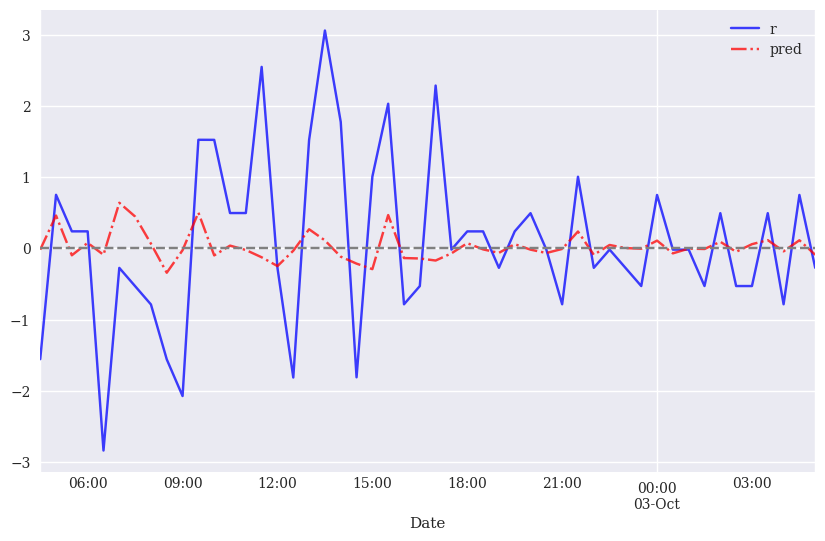

In [9]:
y = model.predict(g,verbose=False)
data['pred'] = np.nan 
data['pred'].iloc[lags:]=y.flatten()
data.dropna(inplace=True)
data[['r','pred']].iloc[50:100].plot(figsize=(10,6),style=['b','r-.'],alpha=0.75)
plt.axhline(0,c='grey',ls='--')

In [10]:
from sklearn.metrics import accuracy_score
accuracy_score(np.sign(data['r']),np.sign(data['pred']))

0.6792923565434339

In [11]:
split = int(len(r)*0.8)
train = r[:split]
test = r[split:]
g = tf.keras.preprocessing.sequence.TimeseriesGenerator(train,train,length=lags,batch_size=5)
model = create_rnn_model(hu=100)

/Users/baijuyadav/Desktop/deeplearningfromscratch/deeplearningscratch/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [14]:
%%time
model.fit(g,epochs=100,steps_per_epoch=10,verbose=False)


/Users/baijuyadav/Desktop/deeplearningfromscratch/deeplearningscratch/lib/python3.12/site-packages/keras/src/trainers/epoch_iterator.py:116: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


CPU times: user 1.58 s, sys: 158 ms, total: 1.74 s
Wall time: 1.4 s


In [16]:
g_ = tf.keras.preprocessing.sequence.TimeseriesGenerator(test,test,length=lags,batch_size=5)
y = model.predict(g_)
accuracy_score(np.sign(test[lags:]),np.sign(y))

176/176 ━━━━━━━━━━━━━━━━━━━━ 0s 735us/step


0.6719817767653758